## Parametric Driving 
`scqubits` can simplify simulations of dynamics using `qutip`, by automating the building of the dynamical Hamiltonians that can be directly provided to `qutip`'s solver routines such as `mesolve`, `mcsolve`, etc. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq

For instance, consider a fluxonium circuit. We will try to drive the fluxonium qubit with both charge and flux drives.

In [2]:
# Let's start by defining a fluxonium
inp_yaml = """
branches:
- [JJ, 1, 2, 4, 0.5]
- [L, 1, 2, 1.3]
- [C, 1, 2, 2]
"""
circ = scq.Circuit(inp_yaml, from_file=False, use_dynamic_flux_grouping=True, ext_basis="discretized")
circ.cutoff_ext_1 = 100
circ.Φ1 = 0.5

# defining Hierarchical diagonalization to limit to the lowest 10 levels
# Hierarchical diagonalization is recommended for time evolution, which generally involves large number of matrix diagonalizations.
circ.configure(system_hierarchy=[[1]], subsystem_trunc_dims=[10])
circ

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Circuit_1

In [3]:
eigs = circ.eigenvals()
eigs - eigs[0]

array([0.        , 0.1734474 , 2.36189081, 3.65328642, 5.59769016,
       7.63584593])

Spectral data:   0%|          | 0/81 [00:00<?, ?it/s]

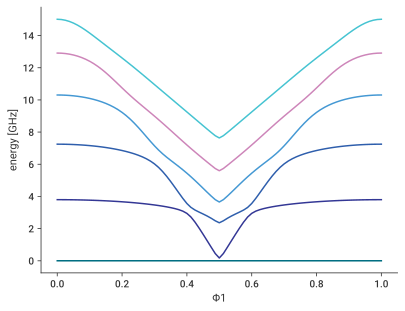

In [4]:
circ.plot_evals_vs_paramvals("Φ1", np.linspace(0, 1, 81), subtract_ground=True);

## Time dependent drives
We need to decide on the parameters we would want to modulate with time. In the above instance, let us try driving the fluxonium with both charge and flux drives. For flux driving a fluxonium, `use_dynamic_flux_grouping` should be set to `True` (refer to [Hierarchical diagonalization](./custom_circuit_hd.ipynb)). For flux driving, let us choose the parameter $\Phi_1$.

Note that for charge driving the fluxonium, there are no terms in the Hamiltonian of the form $ng*Q_1$, where $ng$ is offset charge and $Q_1$ is the charge operator. Therefore, we will use the option `extra_terms` in the method `hamiltonian_for_qutip_dynamics` to add the term $Q1*ng1$ and use the variable $ng1$ to simulate an external charge drive. 

We can now define the time dependent functions which give the value of the above parameters at a given time. Do note, that the values set to the corresponding attributes of the `Circuit` module (in this case the attribute $\Phi_1$) will not be used. 

In [5]:
# Define time dependent functions for the parameters 
def flux(t, args):
        freq = args["freq"]
        return 0.001*np.sin(2*np.pi*freq*t) + 0.5
# to charge drive the fluxonium, we need an extra parameter ng1. This can be added using extra_terms
def charge(t, args):
    freq = args["freq"]
    return 0.02*np.sin(2*np.pi*freq*t + np.pi/2)

Now, the method `hamiltonian_for_qutip_dynamics` can be called to generate the necessary parts of the Hamiltonian - time independent, operators and their time depedentent coefficients. The output `H_mesolve` in the code snippet below, can directly be forwarded to qutip function `mesolve`.  

In [6]:
# Generating necessary operators and time dependent coefficients
H_mesolve, *H_sym_ref = circ.hamiltonian_for_qutip_dynamics(free_var_func_dict={"Φ1": flux, "ng1": charge},
                                                            extra_terms="Q1*ng1", 
                                                            prefactor=np.pi*2)
# H_mesolve can be used to evolve the system using qutip functions like mesolve

# ground state as initial state
eigs, evecs = circ.eigensys(evals_count=5)
wf0 = qt.Qobj(evecs[:, 0]) 

initial_state_proj = wf0 * wf0.dag() # to see the overlap
tf = 100 # final time in nanoseconds
freq = eigs[1] - eigs[0] # transition frequency between the first two states

# time evolve the system
result = qt.mesolve(H_mesolve, wf0, np.linspace(0, tf, 500), args={"freq": freq}, e_ops=[initial_state_proj])

Text(0, 0.5, 'Ground state population')

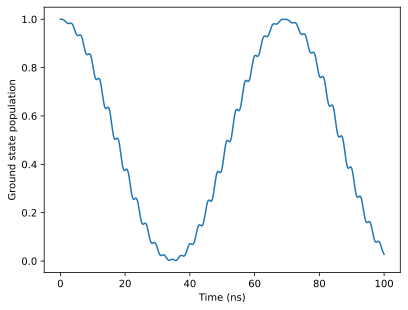

In [7]:
fig, ax=plt.subplots()
ax.plot(result.times, result.expect[0])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Ground state population')

Note that the step-like features over the sinusiod in the above plot is because we have not used RWA in the drive Hamiltonian. 

## Example Floquet Simulation
We can also explore a Floquet simulation

In [13]:
# defining Hierarchical diagonalization to limit to the lowest two states
circ.configure(system_hierarchy=[[1]], subsystem_trunc_dims=[2])

all_eigs = []
flux_vals = np.linspace(0.48, 0.58, 61)
for flux in flux_vals:
    
    circ.Φ1 = flux
    eigs, evecs = circ.eigensys(evals_count=2)
    psi0 = qt.Qobj(evecs[:, 0])
    freq = 510e-3
    
    def flux_time_dependent(t, args):
        freq = args["freq"]
        flux = args["flux"]
        return 0.028*np.cos(2*np.pi*freq*t) + flux
    
    t = np.linspace(0, 1/freq, 300)
    H_mesolve, *b = circ.hamiltonian_for_qutip_dynamics(free_var_func_dict={"Φ1": flux_time_dependent}, prefactor=np.pi*2)
    # calculating the floquet energies
    res = qt.propagator(H_mesolve, t=t, args={"freq": freq, "flux": flux})
    u_eigs = res[-1].eigenenergies()
    floquet_eigs = np.arctan2(np.real(u_eigs), np.imag(u_eigs))
    floquet_eigs.sort()
    floquet_eigs = floquet_eigs * freq / (2*np.pi)
    all_eigs.append(floquet_eigs)


Text(0, 0.5, 'Floquet energies (GHz)')

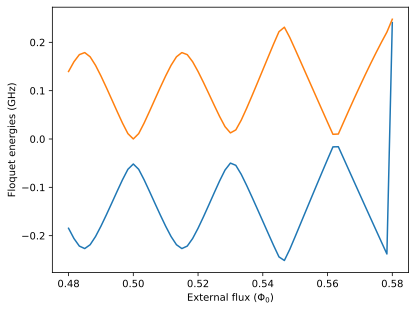

In [14]:
fig, ax=plt.subplots()
plt.plot(flux_vals, all_eigs)
ax.set_xlabel(r'External flux ($\Phi_0$)')
ax.set_ylabel('Floquet energies (GHz)')